In [20]:
from Transolver_Basic import Transolver
from fdm_create_dataset import FDMDatasetGenerator

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
import numpy as np

device = torch.device("cuda")
print('Device: ', device)


Device:  cuda


In [36]:
n_train = 2000
n_test = 500
batch_size = 8
lr = 1e-5

temp_min = 273
temp_max = 5000

In [31]:
class ZNormalizer():
    def __init__(self, X):
        self.mean = X.mean(dim=(0, 1), keepdim=True)
        self.std = X.std(dim=(0, 1), keepdim=True) + 1e-8
        print('ZNormalizer initialized with mean: ', self.mean, 'std: ', self.std)
    
    def to(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

    def encode(self, x):
        x = (x - self.mean) / (self.std)
        return x

    def decode(self, x):
        return x * self.std + self.mean

class MinMaxNormalizer():
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
        print('MinMaxNormalizer initialized with min_val: ', self.min_val, 'max_val: ', self.max_val)

    def to(self, device):
        self.min_val = self.min_val.to(device)
        self.max_val = self.max_val.to(device)
        return self

    def cuda(self):
        self.min_val = self.min_val.cuda()
        self.max_val = self.max_val.cuda()

    def cpu(self):
        self.min_val = self.min_val.cpu()
        self.max_val = self.max_val.cpu()

    def encode(self, x):
        return (x - self.min_val) / (self.max_val - self.min_val)

    def decode(self, x):
        return x * (self.max_val - self.min_val) + self.min_val

In [44]:
generator = FDMDatasetGenerator(
    dataset_path="fdm_dataset.pkl",
    metadata_path="fdm_metadata.json"
)


X = torch.from_numpy(np.array(generator.dataset['inputs'])).float()
spatial_cords = X[:, :, :2]
spatial_normalizer = MinMaxNormalizer(spatial_cords.min(), spatial_cords.max())
spatial_cords = spatial_normalizer.encode(spatial_cords)
material_props = X[:, :, 2:5]
material_normalizer = ZNormalizer(material_props)
material_props = material_normalizer.encode(material_props)
input_temp = X[:, :, 5:6]
temp_normalizer = MinMaxNormalizer(temp_min, temp_max)
input_temp = temp_normalizer.encode(input_temp)
source_power = X[:, :, 6:7]
source_power_normalizer = ZNormalizer(source_power)
source_power = source_power_normalizer.encode(source_power)
boundary_cond = X[:, :, 7:]

X = torch.cat((spatial_cords, material_props, input_temp, source_power, boundary_cond), dim=2)
print(X.shape)


Y = torch.from_numpy(np.array(generator.dataset['outputs'])).float()
Y = temp_normalizer.encode(Y)
print(Y.shape)

total_samples = X.shape[0]

np.random.seed(42)  # Fixed seed for reproducibility
perm = np.random.permutation(total_samples)
train_idx = perm[:n_train]
test_idx = perm[n_train:n_train+n_test]
X_train = X[train_idx].float().to(device)
Y_train = Y[train_idx].float().to(device)
X_test = X[test_idx].float().to(device)
Y_test = Y[test_idx].float().to(device)

print('X_train.shape: ', X_train.shape, 'Y_train.shape: ', Y_train.shape)
print('X_test.shape: ', X_test.shape, 'Y_test.shape: ', Y_test.shape)


Loaded existing dataset with 8500 samples
Loaded metadata with 25 simulations
MinMaxNormalizer initialized with min_val:  tensor(0.) max_val:  tensor(0.2000)
ZNormalizer initialized with mean:  tensor([[[  35., 7700.,  500.]]]) std:  tensor([[[1.0000e-08, 1.0000e-08, 1.0000e-08]]])
MinMaxNormalizer initialized with min_val:  273 max_val:  5000
ZNormalizer initialized with mean:  tensor([[[25976730.]]]) std:  tensor([[[2.8852e+08]]])
torch.Size([8500, 2601, 8])
torch.Size([8500, 2601, 1])
X_train.shape:  torch.Size([2000, 2601, 8]) Y_train.shape:  torch.Size([2000, 2601, 1])
X_test.shape:  torch.Size([500, 2601, 8]) Y_test.shape:  torch.Size([500, 2601, 1])


In [45]:
class SpatialDataset(Dataset):
    """Dataset class for spatial data that handles variable-sized samples."""
    def __init__(self, X, Y, device=None):
        """
        Args:
            X: List or array of input tensors/arrays
            Y: List or array of output tensors/arrays
            device: Device to move tensors to (optional)
        """
        self.X = X
        self.Y = Y
        self.device = device
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        
        # Convert to tensor if needed
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x).float()
        if not isinstance(y, torch.Tensor):
            y = torch.from_numpy(y).float()
        
        # Move to device if specified
        if self.device is not None:
            x = x.to(self.device)
            y = y.to(self.device)
        
        return x, y

In [46]:
dataset_train = SpatialDataset(X_train, Y_train, device)
dataset_test = SpatialDataset(X_test, Y_test, device)

In [47]:
training_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True
)
validation_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False
)

torch.Size([8, 2601, 8])
torch.Size([8, 2601, 1])


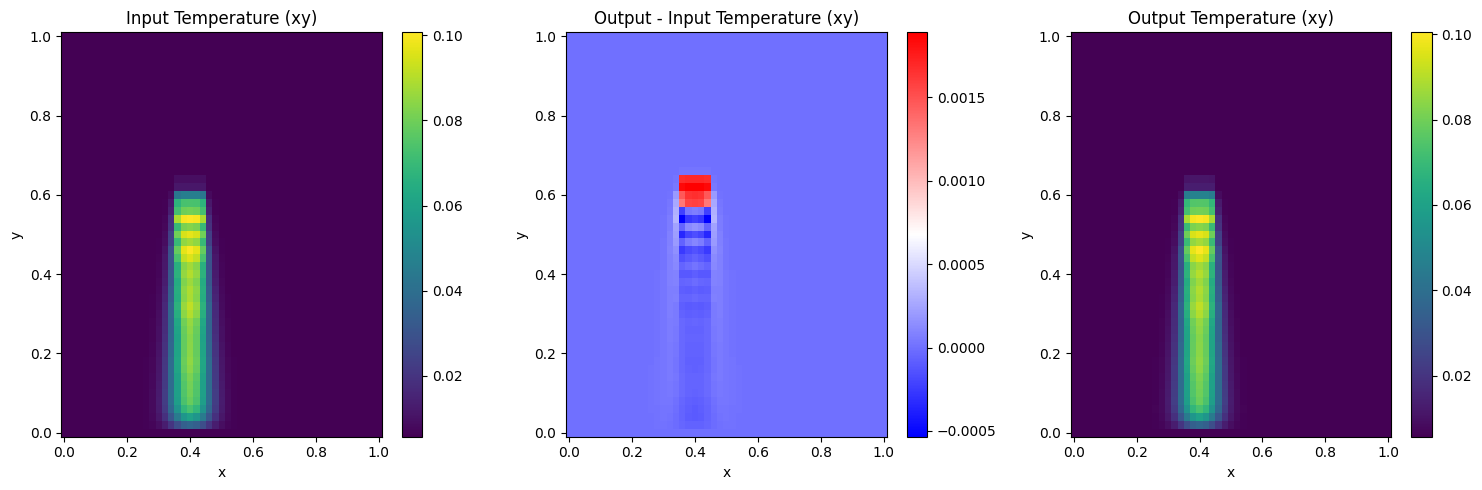

In [53]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(training_loader)
data = next(dataiter)
x, y = data  # x: [B, N, features], y: [B, N, 1]
print(x.shape)
print(y.shape)

# Take the first example in the batch
x0 = x[0]  # [N, features]
y0 = y[0]  # [N, 1]

# Get x, y coordinates and temperatures
x_coords = x0[:, 0].cpu().numpy()
y_coords = x0[:, 1].cpu().numpy()
input_temp = x0[:, 5].cpu().numpy()
output_temp = y0[:, 0].cpu().numpy()

# Compute difference (output minus input)
diff_temp = output_temp - input_temp

# Guess grid size
N = int(np.sqrt(x_coords.shape[0]))

# Reshape for 2D plotting
x_grid = x_coords.reshape(N, N)
y_grid = y_coords.reshape(N, N)
input_temp_2d = input_temp.reshape(N, N)
output_temp_2d = output_temp.reshape(N, N)
diff_temp_2d = diff_temp.reshape(N, N)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
pcm1 = axs[0].pcolormesh(x_grid, y_grid, input_temp_2d, shading='auto')
fig.colorbar(pcm1, ax=axs[0])
axs[0].set_title('Input Temperature (xy)')

pcm2 = axs[1].pcolormesh(x_grid, y_grid, diff_temp_2d, shading='auto', cmap='bwr')
fig.colorbar(pcm2, ax=axs[1])
axs[1].set_title('Output - Input Temperature (xy)')

pcm3 = axs[2].pcolormesh(x_grid, y_grid, output_temp_2d, shading='auto')
fig.colorbar(pcm3, ax=axs[2])
axs[2].set_title('Output Temperature (xy)')

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [54]:
model = Transolver(
    space_dim=2,
    n_layers=4,
    n_hidden=128,
    dropout=0.0,
    n_head=8,
    act='gelu',
    mlp_ratio=1,
    fun_dim=6,
    out_dim=1,
    slice_num=32
)
model.to(device)

Transolver(
  (preprocess): MLP(
    (linear_pre): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): GELU(approximate='none')
    )
    (linear_post): Linear(in_features=256, out_features=128, bias=True)
    (linears): ModuleList()
  )
  (blocks): ModuleList(
    (0-2): 3 x Transolver_block(
      (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (Attn): Physics_Attention_Simple(
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0.0, inplace=False)
        (in_project_x): Linear(in_features=128, out_features=128, bias=True)
        (in_project_slice): Linear(in_features=16, out_features=32, bias=True)
        (to_q): Linear(in_features=16, out_features=16, bias=False)
        (to_k): Linear(in_features=16, out_features=16, bias=False)
        (to_v): Linear(in_features=16, out_features=16, bias=False)
        (to_out): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Dropout

In [55]:
torch.cuda.empty_cache()

In [58]:
# Setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = torch.nn.MSELoss(reduction='mean')

for epoch in range(20):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for x, y in training_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        
        loss.backward()
        
        # Clip gradients - this is CRITICAL
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        # Optional: print gradient norm to monitor
        if num_batches % 10 == 0:
            pass
            # print(f"Grad norm: {grad_norm:.2f}, Loss: {loss.item():.6f}")
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.6f}")

Epoch 1, Avg Loss: 0.001312
Epoch 2, Avg Loss: 0.001216
Epoch 3, Avg Loss: 0.001141
Epoch 4, Avg Loss: 0.001052
Epoch 5, Avg Loss: 0.000944
Epoch 6, Avg Loss: 0.000824
Epoch 7, Avg Loss: 0.000725
Epoch 8, Avg Loss: 0.000637
Epoch 9, Avg Loss: 0.000540
Epoch 10, Avg Loss: 0.000419
Epoch 11, Avg Loss: 0.000265
Epoch 12, Avg Loss: 0.000113
Epoch 13, Avg Loss: 0.000037
Epoch 14, Avg Loss: 0.000019
Epoch 15, Avg Loss: 0.000014
Epoch 16, Avg Loss: 0.000012
Epoch 17, Avg Loss: 0.000010
Epoch 18, Avg Loss: 0.000009
Epoch 19, Avg Loss: 0.000008
Epoch 20, Avg Loss: 0.000008


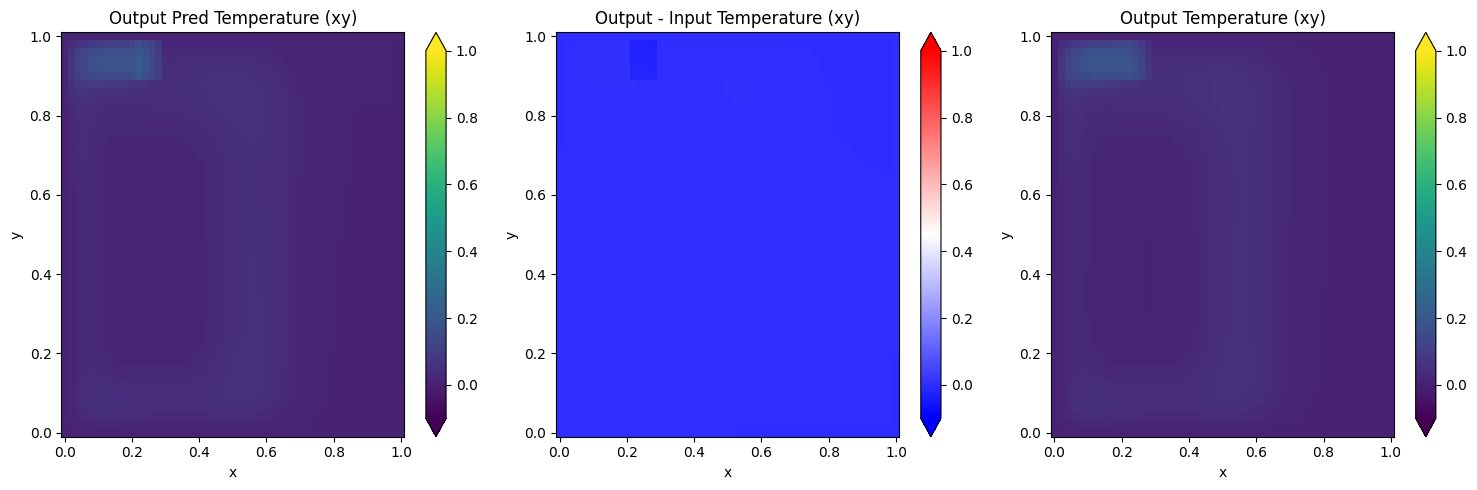

In [81]:
data = next(dataiter)
x, y = data  # x: [B, N, features], y: [B, N, 1]

# Take the first example in the batch
x0 = x[0]  # [N, features]
y0 = y[0]  # [N, 1]
y_pred = model(x0)
y_pred.shape

# # Get x, y coordinates and temperatures
x_coords = x0[:, 0].cpu().numpy()
y_coords = x0[:, 1].cpu().numpy()
input_temp = x0[:, 5].cpu().numpy()
output_temp = y0[:, 0].cpu().numpy()

output_temp_pred = y_pred[:,0].cpu().detach().numpy()

# Compute difference (output minus input)
diff_temp = output_temp - output_temp_pred

# Guess grid size
N = int(np.sqrt(x_coords.shape[0]))

# Reshape for 2D plotting
x_grid = x_coords.reshape(N, N)
y_grid = y_coords.reshape(N, N)
output_temp_2d = output_temp.reshape(N, N)
output_temp_pred_2d = output_temp_pred.reshape(N, N)
diff_temp_2d = diff_temp.reshape(N, N)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmin, vmax = -0.1, 1.0

pcm1 = axs[0].pcolormesh(x_grid, y_grid, output_temp_pred_2d, shading='auto', vmin=vmin, vmax=vmax)
fig.colorbar(pcm1, ax=axs[0], extend='both')
axs[0].set_title('Output Pred Temperature (xy)')

pcm2 = axs[1].pcolormesh(x_grid, y_grid, diff_temp_2d, shading='auto', cmap='bwr', vmin=vmin, vmax=vmax)
fig.colorbar(pcm2, ax=axs[1], extend='both')
axs[1].set_title('Output - Input Temperature (xy)')

pcm3 = axs[2].pcolormesh(x_grid, y_grid, output_temp_2d, shading='auto', vmin=vmin, vmax=vmax)
fig.colorbar(pcm3, ax=axs[2], extend='both')
axs[2].set_title('Output Temperature (xy)')

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
loss_fn = torch.nn.MSELoss()

In [34]:
def train_epoch(epoch_index, tb_writer=None):
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(training_loader):
        inputs, outputs = data
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()

        outputs_pred = model(inputs)
        loss = loss_fn(outputs_pred, outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 5 == 4:
            last_loss = running_loss / 5
            print(f"  batch {i + 1} loss: {last_loss}")
            if tb_writer is not None:
                tb_x = epoch_index * len(training_loader) + i + 1
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0
    return last_loss


In [35]:
writer = None
epoch_number = 0

epochs = 50

best_vloss = 1_000_000.0

for epoch in range(epochs):
    print(f"Epoch {epoch_number + 1} of {epochs}")

    model.train(True)
    avg_loss = train_epoch(epoch_number, writer)

    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train: {avg_loss: 4.4}  validation: {avg_vloss: 4.4}')

    epoch_number += 1



Epoch 1 of 50
  batch 5 loss: 141297.94375
  batch 10 loss: 156745.0640625
  batch 15 loss: 161490.4515625
  batch 20 loss: 239599.95625
  batch 25 loss: 261791.790625
  batch 30 loss: 206114.90625
  batch 35 loss: 310691.20625
  batch 40 loss: 183954.7109375
  batch 45 loss: 230502.009375
  batch 50 loss: 221327.478125
  batch 55 loss: 197485.071875
  batch 60 loss: 261883.853125
  batch 65 loss: 196249.609375
  batch 70 loss: 203039.6859375
  batch 75 loss: 155708.8671875
  batch 80 loss: 193223.34375
  batch 85 loss: 179082.9140625
  batch 90 loss: 218556.5359375
  batch 95 loss: 138912.496875
  batch 100 loss: 247459.1625
  batch 105 loss: 202807.5703125
  batch 110 loss: 212325.271875
  batch 115 loss: 263625.490625
  batch 120 loss: 229689.7875
  batch 125 loss: 202506.878125
  batch 130 loss: 174860.1125
  batch 135 loss: 206808.1546875
  batch 140 loss: 208518.5234375
  batch 145 loss: 146936.621875
  batch 150 loss: 145539.24375
  batch 155 loss: 234201.928125
  batch 160 loss

KeyboardInterrupt: 